### Using the Pytorch

#### Input Data -
Reviews and their labels (sentiments)
#### Output -
Model for predicting sentiment class
#### Notes -
I am using a feed forward 1 hidden layer net. Using only count vectors as features.

###### Task 1 - Gathering the features

The idea is to load the data from the file and create the input matrix X

In [1]:
#Keeping it simple word count only as features.
import numpy as np


def get_sent_word_count(sample_file):
    file_as_lines =[]
    sentiments = []
    index = 0
    word_count = {}

    for line in sample_file:
        line = line.strip()
        sentiments.append(int(line[-1]))
        line = line[:-1].strip()
        
        #skip punctuations
        chars_to_avoid = '-:,;[({})]!?'
        for word in line.split():
            if word not in word_count:
                word = word.lower()
                #remove punctuations in word
                for c in chars_to_avoid:
                    word = word.replace(c, '')
                word_count[word] = [(index, 1)]
            else:
                prev_index, count = word_count[word][-1]
                if prev_index == index:
                    count += 1
                    word_count[word][-1] = (index, count)
                else:
                    count = 1
                    word_count[word].append((index, count))

        index += 1
    
    #print word_count, sentiments
    
    return sentiments, word_count

In [2]:
### Now forming the input vectors from word_count

def get_wcm(word_count, ninputs):
    ## feature_count - no of words
    ## inputs - file count
    features = word_count.keys()
    # print features
    nfeatures = len(features)
    #ninputs = index
    word_count_matrix = np.zeros((ninputs, nfeatures))

    for wcm_col, feature in enumerate(features):
        row_col_list = word_count[feature]
    #     print row_col_list
        for wcm_row, wcm_val in row_col_list:
            word_count_matrix[wcm_row][wcm_col] = wcm_val
    
    return word_count_matrix

# Main function to form the input matrix
#TODO - maybe form a loader class later
def load_data(filename):
    sentiments, word_count = get_sent_word_count(filename)
    #get word_count matrix
    wcm = get_wcm(word_count, len(sentiments))
    sentiments = np.asarray(sentiments)
    data = wcm
    data[:, 0] = sentiments
    return data

sample_file = open("sample.txt", "r")
data = load_data(sample_file)
sample_file.close()
print data[:,0]
print data[:,1:]

[ 0.  1.]
[[ 0.  0.  0.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  0.  0.  0.  0.]]


##### Task2 - Forming the NN

A feed forward net is formed using back-propagation. Here we change as to use of torch.nn framework

In [3]:
import torch
from torch.autograd import Variable

Although the below sigmoid funcs are not needed keeping them redundantly

In [4]:
## Making a  Feed forward NN model

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(y):
    return y * (1.0 - y)

Confusion matrix as a performance evaluator

In [5]:
class ConfusionMatrix:
    
    def __init__(self, tp=0, tn=0, fp=0, fn=0):
        
        self.tp = tp
        self.tn = tn
        self.fp = fp
        self.fn = fn
        
        return
    
    def dispMatrix(self):
        
        s = "|{}|{}|".format(self.tp, self.fn)
        s += "\n-------"
        s += "\n|{}|{}|".format(self.fp, self.tn)
        s += "\n-------"
        print s
        return s
    
    def getPrecision(self):
        
        try:
            return float(self.tp)/float(self.tp + self.fp);
        except:
#             print "Division error!!"
            return 0
        
        assert(False)
        return
    
    def getRecall(self):
        
        try:
            return float(self.tp)/float(self.tp + self.fn);
        except:
#             print "Division error!!"
            return 0
        
        assert(False)
        return
    

In [6]:
import visdom

class MLP_NeuralNetwork(object):
    
    def __init__(self, input, hidden, output, iterations=50,\
                 learning_rate = 0.02, batchsize=100):
        
        # all the parameters' count
        self.input = input # add 1 for bias node
        self.hidden = hidden
        self.output = output
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.batchsize = batchsize
        
        ## Since it is torch.NN, we need inputs and output 
        ## tensors instead of weights
        self.model = torch.nn.Sequential(
          torch.nn.Linear(self.input, self.hidden),
          torch.nn.Sigmoid(),
          torch.nn.Linear(self.hidden, self.output),
          torch.nn.Sigmoid()
        )
        
        self.loss_fn = torch.nn.MSELoss(size_average=False)
        
        # Metrics for the model
        self.cmatrix = ConfusionMatrix()
        self.precision = 0.0
        self.recall = 0.0
        self.f1 = 0.0
        
        #the graphics elements
        self.vis = visdom.Visdom()
        self.win_f1 = None
        self.win_err = None
        
        return
    
    ##Now we go for train and predict
    def train(self, patterns, logs=False):
        
        dtype = torch.FloatTensor
        itercount = 0
        error, prev_error = 0.0, 0.0
        
        #type casting required to make all of them float Tensor
        targets = Variable(patterns[:,0].type(dtype), requires_grad=False)
        inputs = Variable(patterns[:,1:].type(dtype))
        
        for i in range(self.iterations):
            
            if logs:
                print "Iteration - {}".format(i)
            
            ##feed forward
            predictions = self.model(inputs)
            self.error = self.loss_fn(predictions, targets)
            
            error = self.error.data[0]
            
            self.model.zero_grad()
            
            self.error.backward() # do backpropagation now
            
            for param in self.model.parameters():
                param.data -= self.learning_rate * param.grad.data
            
            #quantize the predictions to 0 or 1
            predictions = (predictions >= 0.5).type(dtype)
            
            ## TODO - uncomment to set the confusion matrix stats
            self.updateMetrics(targets, predictions)
            
            # Get the vizdom plot
            self.monitorMetrics(itercount)
            
            ## print the error at every 10th iteration
            ## also stop if the error value is too less or its not converging
            
            if i % 10 == 0:
                delta = abs(error - prev_error)
                if delta < 0.000005 or error <= 0.0005:
                    print "breaking the game"
                    break
                prev_error = error
                print('error %-.5f' % error)
            
            itercount += 1
        
        print "Total iterations- {}".format(itercount)
        
        return
    
    def updateMetrics(self, targets, predictions):
        
        for i,_ in enumerate(predictions):
            if predictions[i].data[0] == targets[i].data[0]:
                if targets[i].data[0] == 1.0:
                    self.cmatrix.tp += 1
                else:
                    self.cmatrix.tn += 1
            else:
                if targets[i].data[0] == 1.0:
                    self.cmatrix.fn += 1
                else:
                    self.cmatrix.fp += 1
        
        self.precision = self.cmatrix.getPrecision()
#         print "Precision-{}".format(self.precision)
        self.recall = self.cmatrix.getRecall()
#         print "Recall-{}".format(self.recall)
        if self.precision == 0 and self.recall == 0:
            self.f1 = 0
        else:
            self.f1 = float(2*self.precision*self.recall)/\
                    float(self.precision+self.recall)

            
        return
            
    def monitorMetrics(self, nIteration):
        
        Y = np.asarray([self.error.data[0]])
        X = np.asarray([nIteration])
        
        if not self.win_err:
            self.win_err = self.vis.line(Y,X, opts=\
                                     dict(title='error plot',\
                                         markercolor=np.array([255])))
        else:       
            self.vis.updateTrace(X, Y, win=self.win_err)
        
        Y = np.asarray([self.f1])
        if not self.win_f1:
            self.win_f1 = self.vis.line(Y,X, opts=\
                                     dict(title='f1 plot'))
        else:       
            self.vis.updateTrace(X, Y, win=self.win_f1)
        
        return
    
    
    ## Just to get some output and calc precision/recall
    def test(self, patterns, logs=False):
        ## target val vs predicted val
        tot = len(patterns)
        tp, tn, fp, fn = 0, 0, 0, 0
        dtype = torch.FloatTensor
        targets = Variable(patterns[:,0].type(dtype), requires_grad=False)
        inputs = Variable(patterns[:,1:].type(dtype))
        
        predictions = self.model(inputs)
        predictions = (predictions >= 0.5).type(torch.FloatTensor)
        
        #print type(predictions)
        #print type(targets)
        for i,_ in enumerate(predictions):
            
            if predictions[i].data[0] == targets[i].data[0]:
                if targets[i].data[0] == 1.0:
                    #print targets[i][0], predictions[i][0]
                    tp += 1
                else:
                    tn += 1
            else:
                if targets[i][0] == 1.0:
                    fn += 1
                else:
                    fp += 1
        
        print "tp, fp, tn, fn"
        print tp, fp, tn, fn
        
        try:
            precision = float(tp)/float(tp + fp)
        except:
            precision = 0.0
        try:
            recall = float(tp)/float(tp + fn)
        except:
            recall = 0.0
            
        try:
            fscore = float(2*precision*recall)/float(precision+recall)
        except:
            fscore = 0.0
        
        return (precision, recall, fscore)


In [7]:
## test the NN by feeding in the X_train, X_test - output gives a 
def test_NN(nfeatures, X_train, X_test, iteration=50, neurons=10, learning_rate=0.02):
    # Actual feautres is 1 less
    NN = MLP_NeuralNetwork(nfeatures-1, neurons, 1, iteration, learning_rate)
    print "Begin training!!"
    NN.train(X_train, False)
    print "Done with training! Begin Tests!"
    p, r, f = NN.test(X_test, True)
    print "Test done!!"
    
    return p, r, f


##Now we test the above NN
## Load the data
sample_file = open("yelp_labelled.txt", "r")
X = load_data(sample_file)
print "data loaded!!"
sample_file.close()

ninputs, nfeatures = X.shape
print nfeatures
print ninputs
dtype = torch.FloatTensor
X_test = torch.Tensor(X[:int(0.2*ninputs)]).type(dtype)
X_train = torch.Tensor(X[int(0.2*ninputs):]).type(dtype)

##Uncomment below to have an individual test
test_NN(nfeatures, X_train, X_test, iteration=1000)



data loaded!!
2424
1000
Begin training!!
error 200.95276
error 244.98769
error 255.26541
error 235.75806
error 227.81648
error 224.47012
error 224.93889
error 229.95857
error 234.50011
error 233.42291
error 227.03203
error 218.07259
error 206.89297
error 193.26768
error 177.53993
error 160.87122
error 144.46809
error 126.38390
error 105.43635
error 87.58039
error 70.91177
error 52.79420
error 37.27246
error 25.98798
error 22.33052
error 50.82478
error 15.79206
error 13.14632
error 11.96210
error 11.17510
error 10.59436
error 10.13479
error 9.75497
error 9.43135
error 9.14752
error 8.88880
error 8.63905
error 8.38181
error 8.11819
error 7.87926
error 7.68283
error 7.52185
error 7.38617
error 7.26858
error 7.16438
error 7.07021
error 6.98332
error 6.90068
error 6.81702
error 6.71549
error 6.47138
error 5.89732
error 5.77202
error 5.69599
error 5.63503
error 5.58213
error 5.53460
error 5.49110
error 5.45084
error 5.41331
error 5.37812
error 5.34501
error 5.31374
error 5.28415
error 5.2560

(1.0, 0.6193548387096774, 0.7649402390438247)

##### Task 3 - Lets make a plots of these

First, lets change iterations and check the effect on fscores

In [8]:

# How does changing training iterations affect?
   
iterations = [50, 100, 200, 500]



precisions = []
recalls = []
fscores = []

#keep number of neurons to be 10
for iteration in iterations:
    print "Begin training iteration- {}".format(iteration)
    prec, rec, fscr = test_NN(nfeatures, X_train, X_test, iteration, 10, 0.02)
    precisions.append(prec)
    recalls.append(rec)
    fscores.append(fscr)
    print "Done with iteration -{}".format(iteration)



Begin training iteration- 50
Begin training!!
error 202.21870
error 211.85374
error 261.76532
error 238.29131
error 230.24199
Total iterations- 50
Done with training! Begin Tests!
tp, fp, tn, fn
0 0 88 112
Test done!!
Done with iteration -50
Begin training iteration- 100
Begin training!!
error 200.49733
error 208.12291
error 263.36975
error 242.37692
error 232.28908
error 229.61522
error 231.19913
error 231.20139
error 222.94147
error 206.55118
Total iterations- 100
Done with training! Begin Tests!
tp, fp, tn, fn
12 0 83 105
Test done!!
Done with iteration -100
Begin training iteration- 200
Begin training!!
error 199.82240
error 199.37163
error 271.48053
error 241.81291
error 232.22414
error 230.04262
error 232.65671
error 234.55408
error 229.78964
error 219.04262
error 206.06609
error 191.73019
error 175.97552
error 159.17747
error 142.56853
error 126.84791
error 110.98123
error 94.01676
error 78.82909
error 63.95086
Total iterations- 200
Done with training! Begin Tests!
tp, fp, tn, f

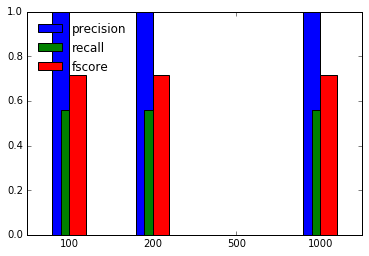

In [14]:
import matplotlib.pyplot as plt
iterations = [10, 20, 30, 40]
iterations = np.asarray(iterations)
## Uncomment below to share the values for precision, recall etc
# print iterations
# print recalls
# print precisions
# print fscores
plt.bar(iterations-1, np.asarray(precisions),width=2, color='b',align='center', label='precision')
plt.bar(iterations, np.asarray(recalls), width=2, color='g',align='center', label='recall')
plt.bar(iterations+1, np.asarray(fscores), width=2,color='r',align='center', label='fscore')
plt.xticks(iterations, ['100', '200', '500', '1000'])
plt.legend(loc='upper left', frameon=False)
plt.show()



Now lets check whether neuron values affect?

In [15]:
### Now test with different neuron values for iteration limit of 100
neurons = [5, 10, 20, 30]

precisions = []
recalls = []
fscores = []

#keep number of iterations to be 100
for neuron in neurons:
    print "Begin training neuron- {}".format(neuron)
    prec, rec, fscr = test_NN(nfeatures, X_train, X_test, 100, neuron, 0.02)
    precisions.append(prec)
    recalls.append(rec)
    fscores.append(fscr)
    print "Done with neuron -{}".format(neuron)



Begin training neuron- 5
Begin training!!
error 202.81497
error 267.63199
error 232.65976
error 223.70927
error 222.81496
error 225.62512
error 223.25516
error 211.83685
error 191.93623
error 170.44685
Total iterations- 100
Done with training! Begin Tests!
tp, fp, tn, fn
28 0 81 91
Test done!!
Done with neuron -5
Begin training neuron- 10
Begin training!!
error 200.54482
error 336.16220
error 241.04959
error 229.76460
error 224.24388
error 220.99992
error 218.02667
error 212.99498
error 206.88260
error 199.88979
Total iterations- 100
Done with training! Begin Tests!
tp, fp, tn, fn
112 0 0 88
Test done!!
Done with neuron -10
Begin training neuron- 20
Begin training!!
error 201.77432
error 372.30136
error 372.88092
error 291.19577
error 237.79047
error 248.10295
error 225.47803
error 221.25693
error 214.72400
error 208.51321
Total iterations- 100
Done with training! Begin Tests!
tp, fp, tn, fn
112 0 0 88
Test done!!
Done with neuron -20
Begin training neuron- 30
Begin training!!
error 21

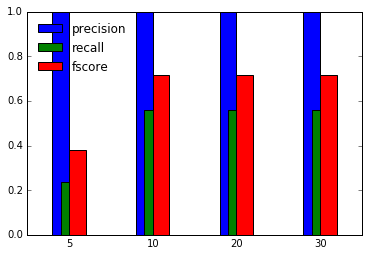

In [16]:
neurons = [10, 20, 30, 40]
neurons = np.asarray(neurons)
## Uncomment below to share the values for precision, recall etc
# print iterations
# print recalls
# print precisions
# print fscores
plt.bar(neurons-1, np.asarray(precisions),width=2, color='b',align='center', label='precision')
plt.bar(neurons, np.asarray(recalls), width=2, color='g',align='center', label='recall')
plt.bar(neurons+1, np.asarray(fscores), width=2,color='r',align='center', label='fscore')
plt.xticks(neurons, ['5', '10', '20', '30'])
plt.legend(loc='upper left', frameon=False)
plt.show()



###### Computing the confusion matrix

In [12]:

import numpy as np
vis = visdom.Visdom()
cm = ConfusionMatrix()
vis.text(cm.dispMatrix())
vis.image(np.ones((3, 10, 10)))

|0|0|
-------
|0|0|
-------


u'pane_350562370c7a28'